# Обучаем и обслуживаем модель TensorFlow с помощью TensorFlow Serving




В данном случае используем keras, как высокоуровневую надстройку к TensorFlow

In [1]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import tempfile
import matplotlib.pyplot as plt
import os
# будем отслеживать все ошибки
import subprocess

import json
import requests
import random
import numpy as np

# Посмотрим на текущую версиб ТФ
print(tf.__version__)

2.3.0


## Создание модели



In [2]:
# Загружаем стандартный датасет Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist

# Создание обучающей и проверочной выборок
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Нормализуем значения пикселей до интервала от 0 до 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Приводим к виду 4D тензора
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Названия классов
class_names = ['Футболка/топ', 'Штаны', 'Свитер', 'Платье', 'Пальто',
               'Сандалия', 'Рубашка', 'Кроссовок', 'Рюкзак', 'Ботинок']

print('\nразмер обучающей выборки: {}'.format(train_images.shape))
print('размер проверочной выборки: {}'.format(test_images.shape))


размер обучающей выборки: (60000, 28, 28, 1)
размер проверочной выборки: (10000, 28, 28, 1)


In [3]:
test_images.shape

(10000, 28, 28, 1)

### Архитектура

In [4]:
model = Sequential()
model.add(Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, strides=2, activation='relu', name='Conv1'))
model.add(Flatten())
model.add(Dense(10, activation=tf.nn.softmax, name='Softmax'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nТочность на проверке: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5265 - accuracy: 0.8165
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3791 - accuracy: 0.8663
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3466 - accuracy: 0.8766
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.32

## Сохраняем модель




Для того, чтобы загрузить модель в TF Serving необходимо сохранит в формате [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model). Это создаст protobuf файл в папке с четко-прописанной иерархией и присвоит номер версии. Каждая версия экспортируется в разные подпапки по указанному пути.

In [5]:
MODEL_DIR = 'E:/Vadim/N_U/nu29_TFServ/models'# создание временной директории для хранения модели
version = 1  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = E:/Vadim/N_U/nu29_TFServ/models\1



In [6]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}


Модель уже сохранена



"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [7]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: E:/Vadim/N_U/nu29_TFServ/models\1\assets

Сохраненная модель:


"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## Протестируем нашу сохраненную модель


Используем утилиту терминала `saved_model_cli` для того, чтобы взглянуть на [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (модели) и [SignatureDefs](../signature_defs) (методы, которые вы можете вызвать)  вашей сохраненной модели.
 Еще больше о SavedModel CLI [тут](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel).

In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_inpu

Здесь выведена информация о нашей модели. В случае, если бы не были известны inputs\outputs, то подпись могла бы нам это показать, как и в этом случае, когда нам все известно.


## Создаем запрос к модели в TensorFlow Serving




Для начала, рассмотрим случайный пример из проверочных данных.

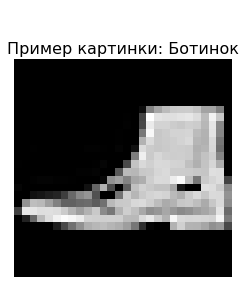

In [9]:
# Функция для просмотра картинки из сета
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

rando = random.randint(0,len(test_images)-1) # номер случайной картинки
show(rando, 'Пример картинки: {}'.format(class_names[test_labels[rando]]))

### Создаем REST запрос

In [23]:
!docker container ls

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [98]:
# проверить, надо ли
#os.environ["MODEL_DIR"] = MODEL_DIR

In [24]:
# sic!
!docker run -d -p 8501:8501 --mount type=bind,source=E:/Vadim/N_U/nu29_TFServ/models,target=/models/fashion_mnist \
        -e MODEL_NAME=fashion_mnist -t tensorflow/serving 

04b3cce09839eb308ffcdbf16ab786b2c5f3baa7c946fcb5c25b4c1e1f347f60


Создаем JSON объект для batch-а 3х инференс-запросов и посмотрим, насколько хорошо модель распознает вещи

In [27]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[10:13].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.5686274509803921], [0.7450980392156863], [0.3803921568627451], [0.42745098039215684], [0.4117647058823529], [0.7333333333333333], [0.2980392156862745], [0.0], [0.0], [0.0], [0.00784313725490196], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.25098039215686274], [0.6666666666666666], [0.6392156862745098], [0.8156862745098039], [0.9529411764705882], [0.9411764705882353], [0.8980392156862745], [0.6784313725490196], [0.6352941176470588], [0.6039215686274509], [0.07058823529411765], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.15294117647058825], [0.6196078431372549], [0.7686274509803922], [0.5843137254901961], [0.7490196078431373], [0.7803921568627451], [0.8745098039215686], [0.9529411764705882], [0.7294117647058823], [0.7490196078

#### Обновленная версия servable/обслуживаемой модели

Пошлем запрос с помощью POST на конечную точку нашего REST сервера и передадим ему 3 образца. Также запросим у сервера последнюю версю обслуживаемой модели, не указывая  конкретно ее версию. 

In [15]:
!docker container ls

CONTAINER ID   IMAGE                COMMAND                  CREATED          STATUS          PORTS                              NAMES
2322531af2ef   tensorflow/serving   "/usr/bin/tf_servingвЂ¦"   36 seconds ago   Up 34 seconds   8500/tcp, 0.0.0.0:8501->8501/tcp   beautiful_poitras


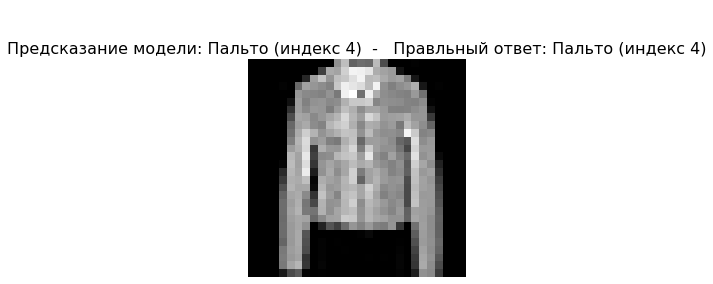

In [35]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_mnist:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(10, 'Предсказание модели: {} (индекс {})  -   Правильный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[10:13][0]], test_labels[10:13][0]))

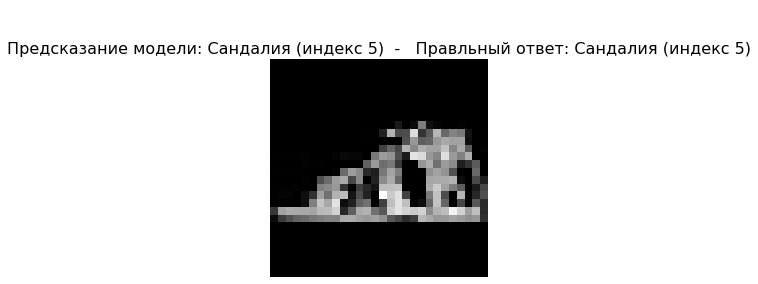

In [33]:
show(11, 'Предсказание модели: {} (индекс {})  -   Правильный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[1])], np.argmax(predictions[1]), class_names[test_labels[10:13][1]], test_labels[10:13][1]))

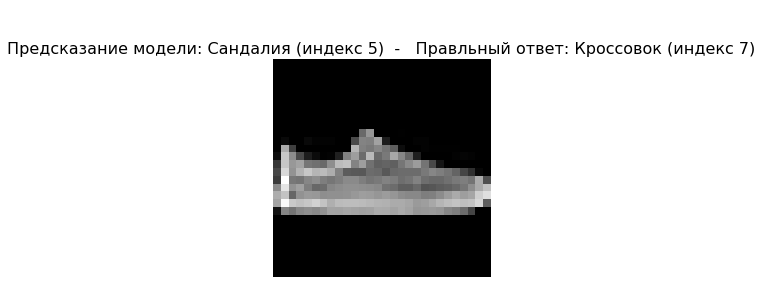

In [34]:
show(12, 'Предсказание модели: {} (индекс {})  -   Правильный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[2])], np.argmax(predictions[2]), class_names[test_labels[10:13][2]], test_labels[10:13][2]))

In [ ]:
len(predictions)

3

In [14]:
TESTDATA = 'E:/Vadim/N_U/nu29_TFServ/models/1'  -v "E:/Vadim/N_U/nu29_TFServ/models/1:/models/1" 
-v "E:\Vadim\test_tf/serving/tensorflow_serving/servables/tensorflow/testdata/saved_model_half_plus_two_cpu:/models/half_plus_two" \

In [99]:
# не катит
!docker run -t --rm -d -p 8501:8501 \
    -v "E:/Vadim/N_U/nu29_TFServ/models:/models/fashion_mnist" \
    -e MODEL_NAME=fashion_mnist  tensorflow/serving  

0c34a687ca3371e831548d9f57b307e2cae3b6da1a4d269eb6fd9082c1f5872e


In [94]:
#!docker run -t --rm -d -p 8501:8501 \
    -v "E:\Vadim\test_tf/serving/tensorflow_serving/servables/tensorflow/testdata/saved_model_half_plus_two_cpu:/models/half_plus_two" \
    -e MODEL_NAME=half_plus_two  tensorflow/serving  

aabe33aec9d568ee74aaa969cd9955f11ff57868bcb665fc3adf464bd9378804


In [111]:
!tools/run_in_docker.sh python tensorflow_serving/example/mnist_client.py --num_tests=1000 --server=127.0.0.1:8501

"tools" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [53]:
#{"instances": [1.0, 2.0, 5.0]}
data = json.dumps({"instances": [100.0, 20.0, 500.0]})

In [54]:
#data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print(data)

{"instances": [100.0, 20.0, 500.0]}


In [55]:
#!pip install -q requests

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/half_plus_two:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']


In [56]:
predictions

[52.0, 12.0, 252.0]

In [36]:
!docker container ls

CONTAINER ID   IMAGE                COMMAND                  CREATED         STATUS         PORTS                              NAMES
04b3cce09839   tensorflow/serving   "/usr/bin/tf_servingвЂ¦"   3 minutes ago   Up 3 minutes   8500/tcp, 0.0.0.0:8501->8501/tcp   sweet_chatelet


In [37]:
!docker stop 04b3cce09839                                    

04b3cce09839


In [38]:
!docker container ls

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


Создаем JSON объект для batch-а 3х инференс-запросов и посмотрим, насколько хорошо модель распознает вещи

In [112]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

#### Обновленная версия servable/обслуживаемой модели

Пошлем запрос с помощью POST на конечную точку нашего REST сервера и передадим ему 3 образца. Также запросим у сервера последнюю версю обслуживаемой модели, не указывая  конкретно ее версию. 

In [102]:
json_response = requests.post('http://localhost:8501/v1/models/fashion_mnist', data=[], headers=headers)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [114]:
import numpy as np

In [113]:
#!pip install -q requests

#import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_mnist:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'Предсказание модели: {} (индекс {})  -   Правльный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

NameError: name 'np' is not defined

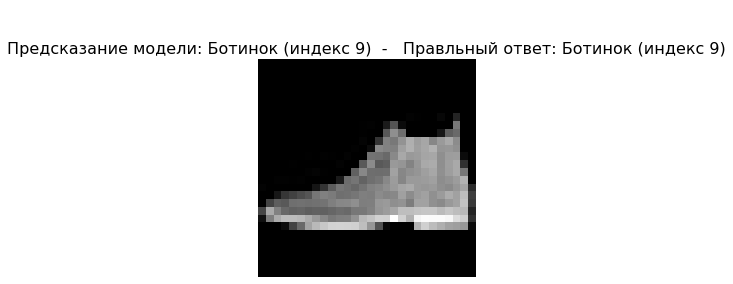

In [115]:
show(0, 'Предсказание модели: {} (индекс {})  -   Правльный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

In [ ]:
len(predictions)

3

In [59]:
json_response.text

'{\n    "error": "Servable not found for request: Latest(1)"\n}'

#### Выбираем конкретную servable\обслуживаемую модель

Поскольку у нас только одна модель, выбираем версию 1

In [ ]:
headers = {"content-type": "application/json"} # здесь вы по сути объявляете формат объекта со всей ифной по инференсу. Строчка с content-type  обязательна
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers) # /versions/1: вот эта часть отвечает за выбор модели

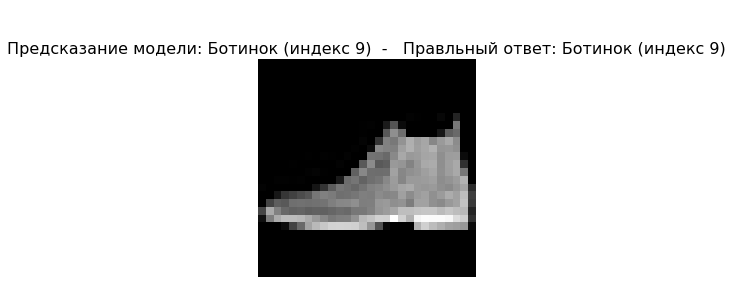

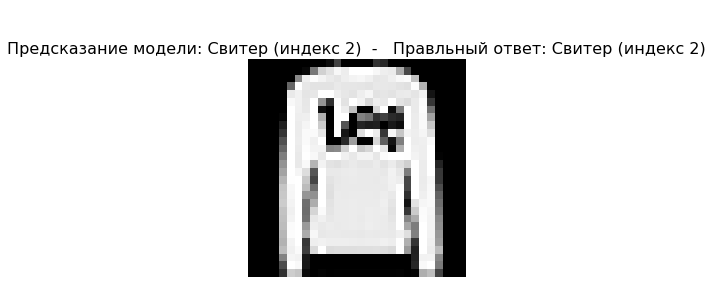

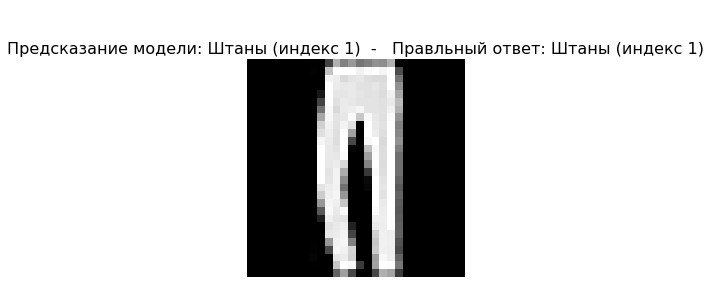

In [ ]:
predictions = json.loads(json_response.text)['predictions'] # в качестве аргумента вытаскиваете текст из json-ответа и вытаскиваете то, что под ключом predictions

# посмотрим на предсказание
for i in range(0,3):
  show(i, 'Предсказание модели: {} (индекс {})  -   Правльный ответ: {} (индекс {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

### Выбор версии модели в rest api

In [ ]:
headers = {"content-type": "application/json"} # здесь вы по сути объявляете формат объекта со всей ифной по инференсу. Строчка с content-type  обязательна
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers) # /versions/1: вот эта часть отвечает за выбор модели

# numba jit

In [ ]:
# Импорт необходимых библиотек
from numba import jit # декоратор numba, который будет оптимизировать наш код
import numpy as np
import pandas as pd
import pyarrow as pa # импорт pyarrow
from pyarrow import csv
import pyarrow.parquet as pq 
import os
import tempfile # библиотека для создания временных директорий/файлов
import math
import random
import json
import time

**Numba** - JIT-компилятор, преобразующий Python код в нативный код как для CPU, так и для GPU. Зачем? Оптимизировать.

Преимущества Numba:
*	Простота в использовании
*	Автоматическая параллелизация
*	Поддержка Numpy объектов
*	Поддержка GPU 

Недостатки Numba:
*	Многоуровневые абстракции создают трудности в дебаггинге и оптимизации.
*	Нет способа взаимодействовать с Python и его модулями в режиме nopython
*	Поддержка не всех классов


In [ ]:
# Создаем случайные наборы чисел
arr = np.arange(1000000).astype(np.float32)

# Функция, которая будет обрабатывать эти числа 
def py_adapt(arr):
  result = np.zeros_like(arr)
  for i in range(len(arr) - 1):
      result[i] = np.sqrt(arr[i] * arr[i + 1])
  return result

In [ ]:
# используем чистый python
%timeit py_adapt(arr)

1 loop, best of 3: 1.47 s per loop


In [ ]:
cur_time = time.time()
py_adapt(arr)
print('time: ', time.time()-cur_time)

time:  1.5884559154510498


In [ ]:
# Используем Numba декоратор с включенным компилятором
@jit(nopython=True)
def nb_adapt(arr):
  result = np.zeros_like(arr)
  for i in range(len(arr) - 1):
      result[i] = np.sqrt(arr[i] * arr[i + 1])  
  return result  

In [ ]:
#Numba + Nopython режим
cur_time = time.time()
%timeit nb_adapt(arr)
print('time: ', time.time()-cur_time)

# Magic команды тут https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html

The slowest run took 213.62 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 520 µs per loop
time:  2.3294293880462646


In [ ]:
# Используем Numba декоратор в объектном режиме (питоновском)
@jit(nopython=False)
def nb_adapt(arr):
  result = np.zeros_like(arr)
  for i in range(len(arr) - 1):
      result[i] = np.sqrt(arr[i] * arr[i + 1])
  return result  

In [ ]:
#Numba + режим объекта
cur_time = time.time()
%timeit -n 1 nb_adapt(arr)
print('time: ', time.time()-cur_time)
#https://numba.pydata.org/ - больше о Numba

The slowest run took 181.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 539 µs per loop
time:  0.10177206993103027


In [ ]:
df = pd.DataFrame(arr)
df.head()

,0
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0


In [ ]:
@jit(nopython=False)
def test_pd(df):
  return df.max()

In [ ]:
test_pd(df)

<ipython-input-24-e1c48f58ffaf>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "test_pd" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-24-e1c48f58ffaf> (3)

File "<ipython-input-24-e1c48f58ffaf>", line 3:
def test_pd(df):
  return df.max()
  ^

  @jit(nopython=False)
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "test_pd" was compiled in object mode without forceobj=True.

File "<ipython-input-24-e1c48f58ffaf>", line 2:
@jit(nopython=False)
def test_pd(df):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mod

0    999999.0
dtype: float32

In [ ]:
df = pd.DataFrame(arr)

In [ ]:
df.shape

(1000000, 1)

In [ ]:
cur_time = time.time()
k = df.to_numpy().reshape(-1)
res = nb_adapt(k)
new_df = pd.DataFrame(res)
print('time: ', time.time()-cur_time)

time:  0.0018057823181152344


![alt text](https://drive.google.com/uc?id=1X0sBLwK85Ch4ztbvsGn-XDoisTGRPFLn)